In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn import metrics
from math import sqrt
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate
df = pd.read_csv('result.csv')

rows_drop = []
for index, row in df.iterrows():
    if row[2:].isnull().sum()/len(row[2:]) > 0.5:
        rows_drop.append(index)
df = df.drop(rows_drop, axis=0)

features = list(df.columns.values)
features.remove('region_name')
features.remove('date')
for feature in features:
    df[feature] = df[feature].fillna(df[feature].mean())
region = df.region_name.unique()
print(region)
def split_region(i):
    val_state = (region[i],region[i+1])
    train = df.loc[~np.in1d(df['region_name'], val_state)]
    val = df.loc[np.in1d(df['region_name'], val_state)]
    return (train, val)


['Alaska' 'Montana' 'North Dakota' 'South Dakota' 'Vermont' 'Wyoming']


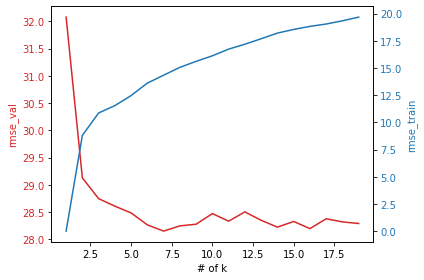

In [16]:
X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
group = df.region_name.astype("category").cat.codes
group_kfold = GroupKFold(6)

rmse = np.empty(19)
rmse_train = np.empty(19)
for k in range(1,20):
    res = cross_validate(KNN(k), X, y, scoring='neg_root_mean_squared_error', groups=group, cv=group_kfold,return_train_score=True)
    rmse[k-1] = res['test_score'].mean() *(-1) 
    rmse_train[k-1] = res['train_score'].mean() *(-1)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('# of k')
ax1.set_ylabel('rmse_val', color=color)
ax1.plot(range(1,20),rmse, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('rmse_train', color=color)  # we already handled the x-label with ax1
ax2.plot(range(1,20),rmse_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [17]:
X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
group = df.region_name.astype("category").cat.codes
group_kfold = GroupKFold(6)

rmse = np.empty(19)
rmse_train = np.empty(19)
for k in range(1,20):
    res = cross_validate(DTR(max_depth=k,random_state=10), X, y, scoring='neg_root_mean_squared_error', groups=group, cv=group_kfold, return_train_score=True)
    rmse[k-1] = res['test_score'].mean() *(-1) 
    rmse_train[k-1] = res['train_score'].mean() *(-1)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('# of k')
ax1.set_ylabel('rmse_val', color=color)
ax1.plot(range(1,20),rmse, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('rmse_train', color=color)  # we already handled the x-label with ax1
ax2.plot(range(1,20),rmse_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


ValueError: x and y must have same first dimension, but have shapes (17,) and (19,)

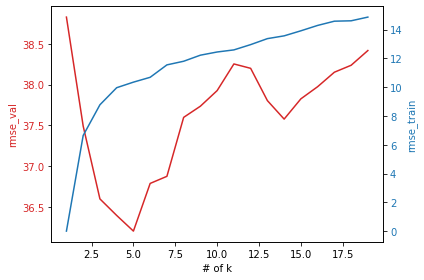

In [13]:
score_list = []
score_list_train = []
train = df.loc[df['date'] < '2020-08-10']
val = df.loc[df['date'] >= '2020-08-10']
for k in range(1,20):
    knn = KNN(k)
    knn.fit(train.iloc[:,2:-1],train.iloc[:,-1])
    y_pred = knn.predict(val.iloc[:,2:-1])
    y_train = knn.predict(train.iloc[:,2:-1])
    score_list.append(sqrt(metrics.mean_squared_error(val.iloc[:,-1],y_pred)))
    score_list_train.append(sqrt(metrics.mean_squared_error(train.iloc[:,-1],y_train)))
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('# of k')
ax1.set_ylabel('rmse_val', color=color)
ax1.plot(range(1,20),score_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('rmse_train', color=color)  # we already handled the x-label with ax1
ax2.plot(range(1,20),score_list_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


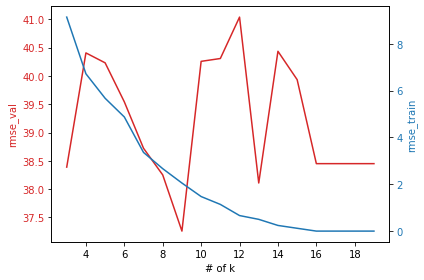

In [18]:
score_list = []
score_list_train = []
train = df.loc[df['date'] < '2020-08-10']
val = df.loc[df['date'] >= '2020-08-10']
for k in range(3,20):
    dtr = DTR(max_depth=k,random_state=10)
    dtr.fit(train.iloc[:,2:-1],train.iloc[:,-1])
    y_pred = dtr.predict(val.iloc[:,2:-1])
    y_train = dtr.predict(train.iloc[:,2:-1])
    score_list.append(sqrt(metrics.mean_squared_error(val.iloc[:,-1],y_pred)))
    score_list_train.append(sqrt(metrics.mean_squared_error(train.iloc[:,-1],y_train)))
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('# of k')
ax1.set_ylabel('rmse_val', color=color)
ax1.plot(range(3,20),score_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('rmse_train', color=color)  # we already handled the x-label with ax1
ax2.plot(range(3,20),score_list_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

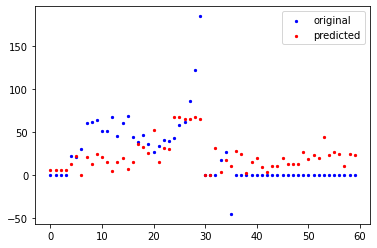

In [19]:
knn = KNN(4)

train, val = split_region(3)
knn.fit(train.iloc[:,3:-1], train.iloc[:,-1])
pred = knn.predict(val.iloc[:,3:-1])
plt.scatter(range(len(val.iloc[:,-1])), val.iloc[:,-1], s=5, color="blue", label="original")
plt.scatter(range(len(val.iloc[:,-1])), pred, s=5, color="red", label="predicted")
plt.legend()
plt.show()